## Imports and data ingestion

`linear_model` for Logistic Regression,

`model_selection` for train-test split and cross-validation,

`metrics` for ROC and AIC

In [2728]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl_lm
import sklearn.ensemble as skl_en
import sklearn.model_selection as skl_ms
import sklearn.metrics as skl_met
import sklearn.preprocessing as skl_pre

In [2729]:
rawData = pd.read_csv('train.csv')

## Get Dummies

`Lead` is `0` if the lead is `female`.

In [2730]:
data = rawData.copy()
data['Lead'] = pd.get_dummies(data['Lead'])

## Feature Engineering

We first extract the number of words spoken by the co-lead.

In [2731]:
data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']

It is probably more important to know proportion of words spoken by lead than the absolute number of words.

In [2732]:
data['Proportion of words lead'] = data['Number of words lead']/data['Total words']

We look at the proportion of dialogue from co-lead as well as the ratio of dialogue between co-lead and lead.

In [2733]:
data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']

Similarly for number of words spoken by male or female actors. However, here we normalize by `Total words - Number of words lead` since this only measures non-lead dialogue. We only need `Proportion of words female` since a hypothetical `Proportion of words male` is just `1 - Proportion of words female`.

In [2734]:
data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])

It might be important to look at the ratio of female actors.

In [2735]:
data['Number of actors'] = data['Number of male actors'] + data['Number of female actors']

In [2736]:
data[['Total words','Number of words lead','Difference in words lead and co-lead','Number of words co-lead','Number words male','Number words female']]

,Total words,Number of words lead,Difference in words lead and co-lead,Number of words co-lead,Number words male,Number words female
0,6394,2251.0,343,1908.0,2631,1512
1,8780,2020.0,1219,801.0,5236,1524
2,4176,942.0,787,155.0,3079,155
3,9855,3440.0,2623,817.0,5342,1073
4,7688,3835.0,3149,686.0,2536,1317
...,...,...,...,...,...,...
1034,2398,1334.0,1166,168.0,761,303
1035,8404,1952.0,187,1765.0,5820,632
1036,2750,877.0,356,521.0,547,1326
1037,3994,775.0,52,723.0,2757,462


In [2737]:
data['Proportion of female actors'] = data['Number of female actors']/data['Number of actors']

Perhaps it is important if the lead or co-lead is oldest.

In [2738]:
data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
data['Older lead'] = pd.get_dummies(data['Older lead'])

In [2739]:
for col in data.columns:
    print("'" + col + "',")

'Number words female',
'Total words',
'Number of words lead',
'Difference in words lead and co-lead',
'Number of male actors',
'Year',
'Number of female actors',
'Number words male',
'Gross',
'Mean Age Male',
'Mean Age Female',
'Age Lead',
'Age Co-Lead',
'Lead',
'Number of words co-lead',
'Proportion of words lead',
'Proportion of words co-lead',
'Ratio words co-lead lead',
'Proportion of words female',
'Number of actors',
'Proportion of female actors',
'Older lead',


We center and scale all computed columns as well as some of the original columns

In [2740]:
cols_to_norm = [
    'Total words',
    'Year',
    'Gross',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Number of actors'#,
    #'Proportion of words lead',
    #'Proportion of words co-lead',
    #'Ratio words co-lead lead',
    #'Proportion of words female',
    #'Proportion of female actors',
]

In [2741]:
scaler = skl_pre.StandardScaler()
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [2742]:
data

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,...,Age Co-Lead,Lead,Number of words co-lead,Proportion of words lead,Proportion of words co-lead,Ratio words co-lead lead,Proportion of words female,Number of actors,Proportion of female actors,Older lead
0,1512,-0.676591,2251.0,343,2,-0.467462,5,2631,0.203383,1.170591,...,2.451143,1,1908.0,0.352049,0.298405,0.847623,0.364953,-0.940919,0.714286,0
1,1524,-0.326435,2020.0,1219,9,0.109371,4,5236,-0.488825,-0.413237,...,-0.123416,0,801.0,0.230068,0.091230,0.396535,0.225444,0.379885,0.307692,1
2,155,-1.002092,942.0,787,7,-3.063211,1,3079,1.746018,0.018716,...,0.125734,0,155.0,0.225575,0.037117,0.164544,0.047928,-0.720785,0.125000,1
3,1073,-0.168675,3440.0,2623,12,0.205509,2,5342,-0.607490,-0.912739,...,-1.036970,0,817.0,0.349061,0.082902,0.237500,0.167264,0.600019,0.142857,1
4,1317,-0.486691,3835.0,3149,8,-1.140434,4,2536,-0.469048,0.370678,...,0.291835,0,686.0,0.498829,0.089230,0.178879,0.341812,0.159751,0.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,303,-1.263021,1334.0,1166,5,-2.582517,2,761,0.414341,0.108306,...,-0.953919,0,168.0,0.556297,0.070058,0.125937,0.284774,-0.940919,0.285714,1
1035,632,-0.381615,1952.0,187,6,-0.755879,2,5820,0.401156,-0.663877,...,-0.123416,1,1765.0,0.232270,0.210019,0.904201,0.097954,-0.720785,0.250000,0
1036,1326,-1.211363,877.0,356,2,0.013232,3,547,-0.383346,-1.901076,...,-0.870869,0,521.0,0.318909,0.189455,0.594071,0.707955,-1.381187,0.600000,1
1037,462,-1.028801,775.0,52,8,-0.371324,3,2757,-0.521788,0.064425,...,-0.289517,1,723.0,0.194041,0.181022,0.932903,0.143523,-0.060383,0.272727,0


Combining all pre-processing into a function

In [2743]:
def pre_process(raw_data, cols_to_norm):
    data = raw_data.copy()
    
    data['Lead'] = pd.get_dummies(data['Lead'])
    data['Number of words co-lead'] = data['Number of words lead'] - data['Difference in words lead and co-lead']
    data['Proportion of words lead'] = data['Number of words lead']/data['Total words']
    data['Proportion of words co-lead'] = data['Number of words co-lead']/data['Total words']
    data['Ratio words co-lead lead'] = data['Number of words co-lead']/data['Number of words lead']
    data['Proportion of words female'] = data['Number words female']/(data['Total words'] - data['Number of words lead'])
    data['Number of actors'] = data['Number of male actors'] + data['Number of female actors']
    data['Proportion of female actors'] = data['Number of female actors']/data['Number of actors']
    data['Older lead'] = data['Age Lead'] < data['Age Co-Lead']
    data['Older lead'] = pd.get_dummies(data['Older lead'])
    
    scaler = skl_pre.StandardScaler()
    data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])
    
    return data

# Logistic Regression

In [2744]:
data = pre_process(rawData, cols_to_norm)

In [2745]:
config = pd.read_csv('config.csv')
trainRatio = config['Train Ratio'][0]
seed = config['Random Seed'][0]
train, test = skl_ms.train_test_split(data, train_size=trainRatio) #, random_state=seed)

In [2746]:
rawFeatures = [
    'Number words female',
    'Total words',
    'Number of words lead',
    'Difference in words lead and co-lead',
    'Number of male actors',
    'Year',
    'Number of female actors',
    'Number words male',
    'Gross',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead'
]

featureSet1 = [
    'Year',
    'Gross',
    'Number of actors',
    'Proportion of female actors',
    'Mean Age Male',
    'Mean Age Female',
    'Age Lead',
    'Age Co-Lead',
    'Total words',
    'Proportion of words lead',
    'Proportion of words co-lead',
    'Ratio words co-lead lead',
    'Proportion of words female',
    'Older lead'
]

In [2747]:
set(cols_to_norm) == set(featureSet1) 

/opt/conda/lib/python3.8/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


False

In [2748]:
features = featureSet1.copy()
#features.remove('Proportion of words female')
target = 'Lead'

In [2749]:
def fit_and_test(classifier, train, test, features, target, suppress_output = False):
    classifier.fit(train[features], train[target])
    if not suppress_output:
        skl_met.plot_roc_curve(classifier, test[features], test[target])
        print('accuracy: ' + str(classifier.score(test[features], test[target])))
        print('     auc: ' + str(skl_met.roc_auc_score(test[target], classifier.predict_proba(test[features])[:,1])) + '\n')
        print(skl_met.classification_report(test[target], classifier.predict(test[features])))
    return classifier

## Lasso

Lasso is L1 regularization

We do 20 folds, use `liblinear` solver that is better for smaller datasets and 10 threads in the cross-validation step.

The method will try 10 values of lambda between `1e-4` and `1e4` to determine the best regularization parameter.

accuracy: 0.9038461538461539
     auc: 0.8909925415949512

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        83
           1       0.79      0.71      0.75        21

    accuracy                           0.90       104
   macro avg       0.86      0.83      0.85       104
weighted avg       0.90      0.90      0.90       104



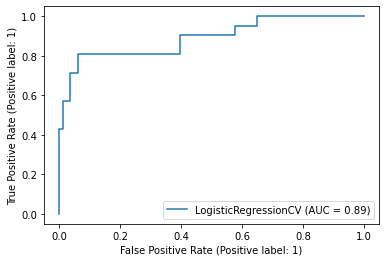

In [2750]:
logRegLasso = fit_and_test(skl_lm.LogisticRegressionCV(Cs=10, cv=20, penalty='l1', solver='liblinear', n_jobs=10), train, test, features, target)

We want to know how the algorithm performs over different splits of training and testing data

In [2751]:
%%time
B = 100
accuracies = []
aucs = []
for i in range(B):
    train, test = skl_ms.train_test_split(data, train_size=trainRatio)
    logRegLasso = fit_and_test(skl_lm.LogisticRegressionCV(Cs=10, cv=10, penalty='l1', solver='liblinear', n_jobs=10), train, test, features, target, suppress_output=True)
    accuracies.append(logRegLasso.score(test[features], test[target]))
    aucs.append(skl_met.roc_auc_score(test[target], logRegLasso.predict_proba(test[features])[:,1]))

CPU times: user 4.27 s, sys: 36.2 ms, total: 4.31 s
Wall time: 23.1 s


In [2752]:
print('mean accuracy: ' + str(np.mean(accuracies)))
print('     mean auc: ' + str(np.mean(aucs)))

mean accuracy: 0.8979807692307693
     mean auc: 0.9283192468298934


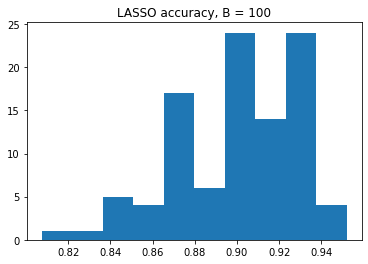

In [2753]:
plt.hist(accuracies)
plt.title(f'LASSO accuracy, B = {B}')
plt.show()

## Ridge

Ridge is L2-regularization

We do 10 folds, use `liblinear` solver that is better for smaller datasets and 10 threads in the cross-validation step.

The method will try 100 values of lambda between `1e-4` and `1e4` to determine the best regularization parameter.

accuracy: 0.9038461538461539
     auc: 0.9060150375939849

              precision    recall  f1-score   support

           0       0.90      0.97      0.94        76
           1       0.91      0.71      0.80        28

    accuracy                           0.90       104
   macro avg       0.91      0.84      0.87       104
weighted avg       0.90      0.90      0.90       104



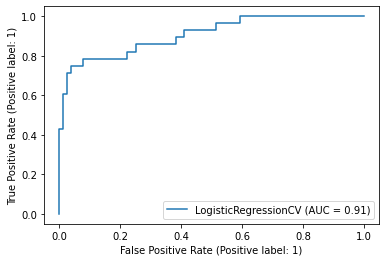

In [2754]:
logRegRidge = fit_and_test(skl_lm.LogisticRegressionCV(Cs=10, cv=20, penalty='l2', solver='liblinear', n_jobs=10), train, test, features, target)

In [2755]:
%%time
B = 400
accuracies = []
aucs = []
for i in range(B):
    train, test = skl_ms.train_test_split(data, train_size=trainRatio)
    logRegLasso = fit_and_test(skl_lm.LogisticRegressionCV(Cs=10, cv=10, penalty='l2', solver='liblinear', n_jobs=10), train, test, features, target, suppress_output=True)
    accuracies.append(logRegLasso.score(test[features], test[target]))
    aucs.append(skl_met.roc_auc_score(test[target], logRegLasso.predict_proba(test[features])[:,1]))

CPU times: user 6.09 s, sys: 147 ms, total: 6.23 s
Wall time: 20.2 s


In [2756]:
print("mean accuracy: " + str(np.mean(accuracies)))
print('     mean auc: ' + str(np.mean(aucs)))

mean accuracy: 0.8984375
     mean auc: 0.9238695273265037


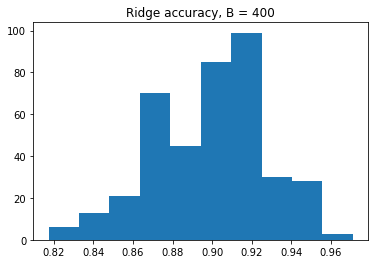

In [2757]:
plt.hist(accuracies)
plt.title(f'Ridge accuracy, B = {B}')
plt.show()

## Comparison

In [2758]:
logRegLasso.C_

array([1291.54966501])

In [2759]:
logRegRidge.C_

array([21.5443469])

In [2760]:
predLasso = logRegLasso.predict(test[features])
predRidge = logRegRidge.predict(test[features])

In [2761]:
logRegLassoCoefs = dict(zip(features, logRegLasso.coef_[0]))

There is a reason that `Proportion of words female` is an indicator that the lead is male. If the `Lead` is male, `Number words female` includes the number of words spoken by the co-lead and hence `Number words female` is the total number of words spoken by **all** female actors while `Number words male` is the number of words spoken by the **non-lead** male actors. Hence, 

In [2762]:
for var, coef in logRegLassoCoefs.items():
    print(f'{var:40} {coef:.5f}')

Year                                     -0.05189
Gross                                    -0.08959
Number of actors                         0.53517
Proportion of female actors              18.44820
Mean Age Male                            0.28539
Mean Age Female                          0.03456
Age Lead                                 -0.38475
Age Co-Lead                              0.19123
Total words                              -0.61461
Proportion of words lead                 2.03709
Proportion of words co-lead              4.61325
Ratio words co-lead lead                 2.75219
Proportion of words female               -11.51988
Older lead                               -1.20364


In [2763]:
logRegRidgeCoefs = dict(zip(features, logRegRidge.coef_[0]))

In [2764]:
for var, coef in logRegRidgeCoefs.items():
    print(f'{var:40} {coef:.5f}')

Year                                     0.00080
Gross                                    -0.05069
Number of actors                         0.48936
Proportion of female actors              17.17039
Mean Age Male                            0.17597
Mean Age Female                          -0.00838
Age Lead                                 -0.34007
Age Co-Lead                              0.22842
Total words                              -0.53862
Proportion of words lead                 2.64158
Proportion of words co-lead              3.75131
Ratio words co-lead lead                 3.14909
Proportion of words female               -10.65164
Older lead                               -1.13606


In [2765]:
sum(predLasso == predRidge)/len(test)

0.9903846153846154

In [2766]:
pd.crosstab(test[target], predLasso)

col_0,0,1
Lead,,
0,74,2
1,3,25


In [2767]:
pd.crosstab(test[target], predRidge)

col_0,0,1
Lead,,
0,75,1
1,3,25
